Algoritma Naïve Bayes melakukan prediksi data dengan menggunakan perhitungan Teorema Bayes. Teorema Bayes merupakan pendekatan statistik yang digunakan untuk menghitung probabilitas suatu hipotesis berdasarkan bukti dan data baru (3). Persamaan Teorema Bayes ditunjukkan pada Persamaan (1), sedangkan penerapannya dalam klasifikasi Naïve Bayes dapat ditulis seperti pada Persamaan (2).

Penggunaan Naïve Bayes dikarenakan algoritma ini sangat efektif untuk fitur kategorikal seperti pada dataset jamur. Naïve Bayes bekerja menggunakan Teorema Bayes dengan asumsi independensi antar fitur, sehingga proses perhitungannya menjadi sederhana dan sangat cepat. Algoritma ini juga efisien untuk dataset berukuran besar. Selain itu, penggunaan Laplace smoothing membantu mengatasi masalah zero probability yang muncul akibat nilai yang hilang atau belum pernah muncul sebelumnya. 

Kita akan menggunakan beberapa library Python untuk membantu proses manajemen data dan pemrosesan agar lebih efisien 
- pandas: Digunakan untuk menyimpan informasi dalam bentuk dataframe agar mudah dibaca dan dimanipulasi. 
- numpy: Digunakan untuk operasi matemtika, terutama fungsi np.log yang sangat krusial dalam perhitungan probabilitas Naive Bayes. 
- random: Library Python yang akan digunakan nanti dalam algoritma genetika untuk menghasilkan angka acak.
- matplotlib dan seaborn: Tool untuk melakukan visualisasi data.

In [88]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
import random
from sklearn.metrics import confusion_matrix, f1_score

# EDA (Exploratory Data Analysis)

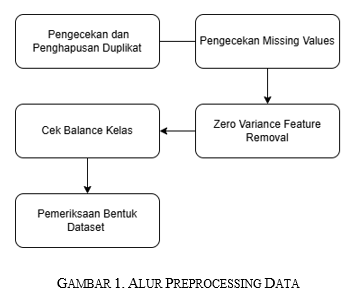

In [89]:
df = pd.read_csv("mushrooms.csv")
print("dataset shape:", df.shape)

dataset shape: (8124, 23)


Dataset berukuran (8124, 23). Ini berarti dataset memiliki 8.124 baris dan 23 kolom. Di mana baris merepresentasikan jumlah total sampel atau observasi jamur yang ada di dalam dataset, sedangkan kolom adalah jumlah atribut atau variabel yang dicatat untuk setiap jamur.

In [90]:
# check duplicates 
duplicates = df.duplicated().sum()
if duplicates > 0: 
    df.drop_duplicates(inplace=True)

Dataset diperiksa menggunakan fungsi duplicated() untuk memastikan tidak ada baris ganda yang memengaruhi pola data. 

Pertama, kita melakukan proses pemeriksaan data yang duplikat dan menghapus data yang hilang tersebut dari dataframe.

In [91]:
# check missing values 
missing = {}
for col in df.columns: 
    if '?' in df[col].unique(): 
        count = df[col].value_counts()['?']
        missing[col] = count 

print(f"missing data: {missing}")

missing data: {'stalk-root': np.int64(2480)}


Kedua, kita melakukan pengecekan entri yang hilang atau "missing valeus" pada kolom dari dataframe. Dari hasil komputasi yang dilakukan, terdapat 2480 instance pada kolom 'stalk-root' yang berisi '?'. Kita akan treat data ini sebagai label/kategori yang valid, untuk menghindari bias data.

In [92]:
# check zero variance columns 
drop_cols = []
for col in df.columns: 
    if df[col].nunique() == 1: 
        drop_cols.append(col)

if drop_cols: 
    print(f"dropping zero variance columns: {drop_cols}")

dropping zero variance columns: ['veil-type']


Kolom veil-type memiliki hanya satu nilai unik, sehingga tidak memberikan informasi apa pun untuk membedakan kelas. Karena tidak memiliki variasi, fitur ini dihapus karena tidak berkontribusi pada performa model. 

C:\Users\HP\AppData\Local\Temp\ipykernel_9724\496750998.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="class", data=df, palette="viridis")


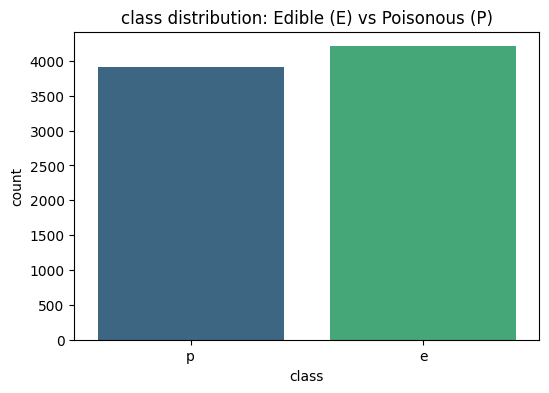

In [93]:
# visualize class balance 
plt.figure(figsize=(6, 4))
sns.countplot(x="class", data=df, palette="viridis") 
plt.title("class distribution: Edible (E) vs Poisonous (P)")
plt.show()

Setelah melakukan visualisasi untuk melihat distribusi data class dari dataset tersebut, ditemukan bahwa proporsi data Poisonous (P) dan Edible (E) tidak jauh beda. Hasilnya menunjukkan bahwa dataset berada dalam kondisi seimbang, sehingga tidak diperlukan teknik resampling tambahan. 

In [94]:
# split data 
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
split_idx = int(0.8 * len(df))
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

print(f"training data: {train_df.shape}")
print(f"test data: {test_df.shape}")

training data: (6499, 23)
test data: (1625, 23)


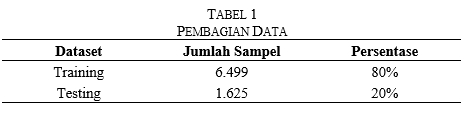

Pembagian 80:20 pada tabel 1 dipilih karena ukuran dataset yang besar, sehingga porsi 80% memberikan cukup data bagi model untuk mempelajari pola dengan baik. Sementara itu, 20% data testing sudah memadai untuk mengukur kemampuan generalisasi. Rasio ini juga merupakan standar umum untuk dataset dengan lebih dari 5.000 sampel.

# Naive Bayes model

Kita akan mendefinisikan "otak" dari model kita dalam bentuk sebuah Class Python. Kode ini merupakan pengembangan dari Naive Bayes standar karena kita menambahkan fitur Hyperparameter Tuning dan Laplace Smoothing yang dinamis.

Berikut adalah komponen utama dari kelas `NaiveBayesClassifier` yang akan kita buat:

1. Inisialisasi (`__init__`):
    - Menerima parameter `alpha` (default 0.5). Ini adalah variabel yang akan diotak-atik oleh *Genetic Algorithm* nantinya untuk mencari nilai smoothing terbaik.


2. Proses Belajar (`fit`):
    - Menghitung Prior: Seberapa sering sebuah kelas muncul (menggunakan Logaritma).
    - Menghitung Likelihood dengan Smoothing: Kita menerapkan rumus *Laplace Smoothing* pada setiap probabilitas fitur:


* Ini mencegah probabilitas menjadi 0 jika ada data kategori yang hilang, sekaligus mencegah probabilitas menjadi tak terhingga jika `alpha` terlalu kecil.


3. Proses Prediksi (`predict`):
    - Menggunakan penjumlahan logaritma () untuk stabilitas numerik.
    - Penanganan Data Asing (`__unseen__`): Jika saat pengujian muncul kategori baru yang tidak ada saat pelatihan, model otomatis menggunakan nilai probabilitas *smoothing* cadangan agar tidak *error*.

Tahapan training pada model Naive Bayes: 
1. Hitung prior probability setiap kelas P(C) = total_sampel / jumlah_kelas
2. Hitung likelihood tiap nilai fitur untuk setiap kelas 
3. Terapkan Laplace Smoothing dengan nilai suatu nilai alpha 
4. Simpan semua probabilitas pada log-space untuk stabilitas numerik

Tahapan prediksi model: 
1. Ambil prior probability kelas 
2. Tambahkan log-likelihood untuk tiap fitur 
3. Pilih kelas dengan nilai log-posterior terbesar

In [95]:
class NaiveBayesClassifier: 
    def __init__(self, alpha=0.5): 
        self.alpha = alpha # tunable hyperparameter
        self.priors = {}
        self.likelihoods = {}
        self.classes = []
        self.features = []
    
    def fit(self, X, y): 
        self.classes = np.unique(y)
        self.features = X.columns
        n_rows = len(y) 

        # 1. priors
        for c in self.classes: 
            self.priors[c] = np.log(len(y[y == c]) / n_rows) 

        # 2. likelihoods with dynamic alpha (tuned parameter)
        self.likelihoods = {feat: {} for feat in self.features}

        for feat in self.features: 
            unique_vals = X[feat].unique()
            n_unique = len(unique_vals) 

            for c in self.classes: 
                self.likelihoods[feat][c] = {}
                subset_c = X[y == c] 
                count_c = len(subset_c) 

                # denominator for smoothing
                denom = count_c + (self.alpha * n_unique)

                for val in unique_vals: 
                    count_val = len(subset_c[subset_c[feat] == val]) 

                    prob = (count_val + self.alpha) / denom
                    self.likelihoods[feat][c][val] = np.log(prob) 

                self.likelihoods[feat][c]["__unseen__"] = np.log(self.alpha / denom)

    def predict(self, X): 
        predictions = [] 

        for _, row in X.iterrows(): 
            posteriors = {} 

            for c in self.classes: 
                posterior = self.priors[c] 

                for feat in self.features: 
                    val = row[feat] 

                    if val in self.likelihoods[feat][c]: 
                        posterior += self.likelihoods[feat][c][val]
                    else: 
                        posterior += self.likelihoods[feat][c]["__unseen__"]
                    
                posteriors[c] = posterior
            
            best_class = max(posteriors, key=posteriors.get) 
            predictions.append(best_class) 

        return predictions

# GA for hyperparameter tuning

Setelah membangun model Naive Bayes, langkah selanjutnya adalah menentukan nilai hyperparameter `alpha` (Laplace Smoothing) yang paling optimal. Daripada menebak-nebak angka secara manual, kita akan membangun sebuah kelas khusus bernama `GeneticsAlgorithmTuner` yang menggunakan prinsip Algoritma Genetika untuk mencari nilai terbaik secara otomatis.

Kelas ini menerapkan algoritma genetika dengan tahapan sebagai berikut:

1. Inisialisasi (`init_pop`):
    - Menciptakan populasi awal yang berisi sekumpulan nilai `alpha` acak (gen) sebagai kandidat solusi.


2. Evaluasi Fitness (`fitness`):
    - Mengukur "kebugaran" setiap individu. Dalam konteks ini, fitness adalah Akurasi Model pada data validasi saat menggunakan nilai `alpha` tersebut.


3. Seleksi Alam (`selection`):
    - Memilih individu terbaik untuk menjadi induk generasi berikutnya. Kita menggunakan metode Tournament Selection, yaitu mengadu dua individu secara acak dan memilih yang akurasinya lebih tinggi.


4. Reproduksi (`crossover`):
    - Mengkombinasikan gen dari dua induk untuk menghasilkan anak (nilai `alpha` baru). Di sini digunakan teknik rata-rata aritmatika dan rata-rata tertimbang.


5. Mutasi (`mutation`):
    - Memberikan perubahan acak kecil pada sebagian populasi. Ini penting untuk menjaga keragaman genetik agar algoritma tidak terjebak pada solusi yang kurang optimal (*local optima*).


6. Siklus Utama (`run`):
    - Menjalankan seluruh proses di atas berulang-ulang selama jumlah generasi yang ditentukan hingga ditemukan nilai `alpha` dengan akurasi tertinggi.

In [96]:
class GeneticsAlgorithmTuner: 
    def __init__(self, X_train, y_train, X_val, y_val, pop_size=10, generations=15, mutation_rate=0.01): 
        self.X_train = X_train
        self.y_train = y_train 
        self.X_val = X_val 
        self.y_val = y_val 
        self.pop_size = pop_size 
        self.generations = generations 
        self.mutation_rate = mutation_rate 
        self.population = [] 

    def init_pop(self): 
        print(f"initializing population with {self.pop_size} individuals")
        for _ in range(self.pop_size): 
            alpha = random.uniform(0.0001, 5.0) 
            self.population.append(alpha) 

    def fitness(self, alpha): 
        model = NaiveBayesClassifier(alpha=alpha) 
        model.fit(self.X_train, self.y_train) 

        # predict
        preds = model.predict(self.X_val)

        # calculate accuracy 
        correct = sum(1 for p, t in zip(preds, self.y_val) if p == t) 
        accuracy = correct / len(self.y_val)
        return accuracy
    
    # tournament selection
    def selection(self, scored_population): 
        parents = []
        for _ in range(self.pop_size): 
            contender_a = random.choice(scored_population)
            contender_b = random.choice(scored_population) 

            if contender_a[1] > contender_b[1]: 
                parents.append(contender_a[0])
            else: 
                parents.append(contender_b[0])
        return parents
    
    def crossover(self, parents): 
        offspring = [] 
        for i in range(0, self.pop_size, 2): 
            parent1 = parents[i] 
            parent2 = parents[i+1] if i+1 < len(parents) else parents[0] 

            child1 = (parent1 + parent2) / 2
            child2 = (parent1 * 0.7) + (parent2 * 0.3) 

            offspring.extend([child1, child2])

        return offspring[:self.pop_size]
    
    def mutation(self, population): 
        mutated_pop = [] 
        for alpha in population: 
            if random.random() < self.mutation_rate: 
                noise = random.uniform(-0.5, 0.5)
                new_alpha = abs(alpha + noise)
                mutated_pop.append(new_alpha) 
            else: 
                mutated_pop.append(alpha)
        return mutated_pop
    
    def run(self): 
        self.init_pop() 

        for gen in range(self.generations): 
            scores = [] 
            for alpha in self.population: 
                acc = self.fitness(alpha) 
                scores.append((alpha, acc)) 

            scores.sort(key=lambda x: x[1], reverse=True)
            best_alpha, best_acc = scores[0]

            print(f"gen {gen+1}: best: alpha = {best_alpha:.4f}, accuracy = {best_acc:.4f}%")

            parents = self.selection(scores) 

            next_gen = self.crossover(parents) 

            self.population = self.mutation(next_gen)
        
        return best_alpha


# evals

Pada tahap ini, kita akan menjalankan seluruh rangkaian eksperimen. Proses ini dirancang secara hati-hati untuk mencegah *data leakage* (kebocoran data), di mana model secara tidak sengaja "mengintip" kunci jawaban.

Langkah-langkah yang dilakukan dalam kode ini adalah:

1. Persiapan Data Validasi (*Validation Split*):
    - Kita tidak boleh menggunakan Test Set untuk proses tuning (pencarian alpha terbaik).
    - Oleh karena itu, kita mengambil sebagian kecil (20%) dari Training Data untuk dijadikan Validation Set.
    - Sub-Train: Digunakan oleh Algoritma Genetika untuk melatih variasi model.
    - Validation: Digunakan untuk mengukur seberapa bagus performa (fitness) dari variasi model tersebut.


2. Eksekusi Algoritma Genetika:
    - Kita menjalankan `GeneticsAlgorithmTuner` dengan populasi 20 individu selama 15 generasi.
    - Algoritma akan berevolusi secara otomatis untuk menemukan nilai smoothing (`alpha`) yang paling optimal.


3. Pelatihan dan Evaluasi Final:
    - Setelah mendapatkan `best_alpha`, kita membangun Model Final.
    - Penting: Model final ini dilatih ulang menggunakan Data Training Utuh (`X_train` & `y_train`) agar model memiliki pengetahuan maksimal.
    - Terakhir, model diuji pada Data Test (`X_test` & `y_test`) yang benar-benar asing (belum pernah dilihat sama sekali selama proses tuning) untuk mendapatkan skor akurasi yang jujur dan objektif.

In [97]:
X_train = train_df.drop('class', axis=1)
y_train = train_df['class']
X_test = test_df.drop('class', axis=1)
y_test = test_df['class']

In [98]:
val_size = int(0.2 * len(train_df))
sub_train_df = train_df.iloc[:-val_size]
val_df = train_df.iloc[-val_size:]

X_sub_train = sub_train_df.drop('class', axis=1)
y_sub_train = sub_train_df['class']

X_val = val_df.drop('class', axis=1)
y_val = val_df['class']

ga = GeneticsAlgorithmTuner(X_sub_train, y_sub_train, X_val, y_val, pop_size=20, generations=15, mutation_rate=0.01)

# Run GA
best_alpha_found = ga.run()

print(f"\nBest Alpha: {best_alpha_found:.4f}")

# Final Test
print("--- Final Evalution ---")
final_model = NaiveBayesClassifier(alpha=best_alpha_found)
final_model.fit(X_train, y_train)
final_preds = final_model.predict(X_test)

correct = sum(1 for p, t in zip(final_preds, y_test) if p == t)
print(f"Final Model Accuracy: {correct / len(y_test):.4%}")

initializing population with 20 individuals
gen 1: best: alpha = 0.6697, accuracy = 0.9515%
gen 2: best: alpha = 0.8358, accuracy = 0.9515%
gen 3: best: alpha = 0.9710, accuracy = 0.9492%
gen 4: best: alpha = 1.2422, accuracy = 0.9438%
gen 5: best: alpha = 1.3028, accuracy = 0.9438%
gen 6: best: alpha = 1.3111, accuracy = 0.9438%
gen 7: best: alpha = 1.2599, accuracy = 0.9438%
gen 8: best: alpha = 1.2732, accuracy = 0.9438%
gen 9: best: alpha = 1.2615, accuracy = 0.9438%
gen 10: best: alpha = 1.2553, accuracy = 0.9438%
gen 11: best: alpha = 1.2683, accuracy = 0.9438%
gen 12: best: alpha = 1.2719, accuracy = 0.9438%
gen 13: best: alpha = 1.2651, accuracy = 0.9438%
gen 14: best: alpha = 1.2628, accuracy = 0.9438%
gen 15: best: alpha = 1.2613, accuracy = 0.9438%

Best Alpha: 1.2613
--- Final Evalution ---
Final Model Accuracy: 95.0154%


Model dievaluasi menggunakan akurasi sebagai metrik utama, yang dihitung dengan membagi jumlah prediksi benar terhadap total prediksi yang dihasilkan model. Selain akurasi, evaluasi dapat diperkuat dengan confusion matrix serta perhitungan precision, recall, dan F1-score sebagai metrik tambahan untuk memberikan gambaran yang lebih komprehensif mengenai performa model.

F1 Score (Poisonous): 0.9455


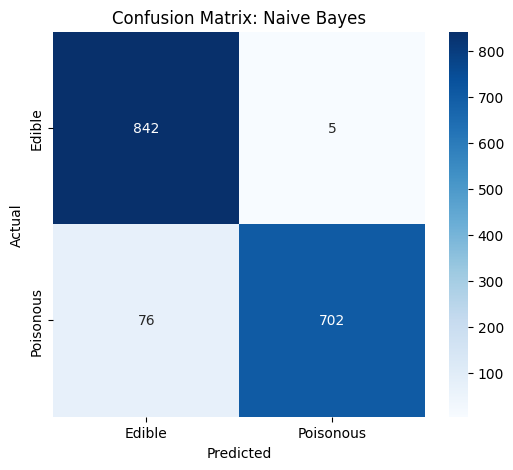

In [99]:
f1 = f1_score(y_test, final_preds, pos_label='p')
print(f"F1 Score (Poisonous): {f1:.4f}")

cm = confusion_matrix(y_test, final_preds, labels=['e', 'p'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Edible', 'Poisonous'], 
            yticklabels=['Edible', 'Poisonous'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Naive Bayes')
plt.show()